In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import f1_score

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
dtype_={'building_id':'int32',
        'geo_level_1_id':'int8',
        'geo_level_2_id':'int16',
        'geo_level_3_id':'int16',
        'count_floors_pre_eq':'int8',
        'age':'int16',
        'area_percentage':'int8',
        'height_percentage':'int8',
        'land_surface_condition':'category',
        'foundation_type':'category',
        'roof_type':'category',
        'ground_floor_type':'category',
        'other_floor_type':'category',
        'has_superstructure_adobe_mud':'int8',
        'has_superstructure_mud_mortar_stone':'int8',
        'has_superstructure_stone_flag':'int8',
        'has_superstructure_cement_mortar_stone':'int8',
        'has_superstructure_mud_mortar_brick':'int8',
        'has_superstructure_cement_mortar_brick':'int8',
        'has_superstructure_timber':'int8',
        'has_superstructure_bamboo':'int8',
        'has_superstructure_rc_non_engineered':'int8',
        'has_superstructure_rc_engineered':'int8',
        'has_superstructure_other':'int8'}

train_values=pd.read_csv('train_values.csv',dtype=dtype_)
train_labels=pd.read_csv('train_labels.csv',dtype={'building_id':'int32','damage_grade':'int8'})

test_values=pd.read_csv('test_values.csv',dtype=dtype_)

# Aca hago mean encoding, mode(moda) encoding y uno mas que es la suma de los 2.

In [3]:
geo_level=train_values.loc[:,['building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id']].merge(train_labels)
gl_by_mean=[np.zeros(geo_level.geo_level_1_id.max()+1),
            np.zeros(geo_level.geo_level_2_id.max()+1),
            np.zeros(geo_level.geo_level_3_id.max()+1)]
gl_by_mode=[np.zeros(geo_level.geo_level_1_id.max()+1),
            np.zeros(geo_level.geo_level_2_id.max()+1),
            np.zeros(geo_level.geo_level_3_id.max()+1)]
gl_combine=[np.zeros(geo_level.geo_level_1_id.max()+1),
            np.zeros(geo_level.geo_level_2_id.max()+1),
            np.zeros(geo_level.geo_level_3_id.max()+1)]

for key,value in geo_level.groupby('geo_level_1_id').agg({'damage_grade':'mean'}).to_dict()['damage_grade'].items():
    gl_by_mean[0][key]=value
for key,value in geo_level.groupby('geo_level_2_id').agg({'damage_grade':'mean'}).to_dict()['damage_grade'].items():
    gl_by_mean[1][key]=value
for key,value in geo_level.groupby('geo_level_3_id').agg({'damage_grade':'mean'}).to_dict()['damage_grade'].items():
    gl_by_mean[2][key]=value
for key,value in geo_level.groupby('geo_level_1_id').agg({'damage_grade':lambda x: stats.mode(x)[0][0]})\
                 .to_dict()['damage_grade'].items():
    gl_by_mode[0][key]=value
for key,value in geo_level.groupby('geo_level_2_id').agg({'damage_grade':lambda x: stats.mode(x)[0][0]})\
                 .to_dict()['damage_grade'].items():
    gl_by_mode[1][key]=value
for key,value in geo_level.groupby('geo_level_3_id').agg({'damage_grade':lambda x: stats.mode(x)[0][0]})\
                 .to_dict()['damage_grade'].items():
    gl_by_mode[2][key]=value
for gl in gl_by_mean:
    for i,value in enumerate(gl):
        if value == 0:
            gl[i]=gl[i-1]
for gl in gl_by_mode:
    for i,value in enumerate(gl):
        if value == 0:
            gl[i]=gl[i-1]
gl_combine=[gl_by_mean[i]+gl_by_mode[i] for i in range(3)]

foundation_dict={'i':0,'w':1,'u':2,'h':3,'r':4}
other_floor_dict={'s':0,'j':1,'q':2,'x':2}

def get_features(features):
    short=features.loc[:,['building_id','geo_level_1_id','geo_level_2_id','geo_level_3_id','foundation_type',\
                          'age','roof_type','ground_floor_type','other_floor_type','count_floors_pre_eq',\
                          'height_percentage','area_percentage']\
                           +[col for col in features.columns if col.startswith('has_superstructure')]]
    short['height_to_area_rt']=short['height_percentage']/short['area_percentage']

    # Aca se elige el encoding que se quiere usar para cada geo_level
    short['geo_level_1_id']=short.agg({'geo_level_1_id':lambda x:gl_by_mean[0][x]})
    short['geo_level_2_id']=short.agg({'geo_level_2_id':lambda x:gl_combine[1][x]})
    short['geo_level_3_id']=short.agg({'geo_level_3_id':lambda x:gl_combine[2][x]})

    # Encodeo las variables categóricas así porque en el TP1 parecían ser las que más peso tenían sobre damage_grade
    short.other_floor_type=short.agg({'other_floor_type':lambda x:other_floor_dict[x]})
    short.foundation_type=short.agg({'foundation_type':lambda x:foundation_dict[x]})
    short.roof_type=short['roof_type']=='x'
    short.ground_floor_type=short['ground_floor_type']=='v'
    return short

In [4]:
short_train=get_features(train_values).merge(train_labels).set_index('building_id')
X, y = short_train.iloc[:,:-1],short_train.iloc[:,-1]

In [5]:
# la métrica mlogloss explicita es para sacar el warning
xg_cls=xgb.XGBClassifier(objective='multi:softprob',eval_metric='mlogloss',\
                         learning_rate=0.178,n_estimators=500,colsample_bytree=0.25,\
                         tree_method='hist')
xg_cls.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.178, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=2,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [7]:
f1_score(y, xg_cls.predict(X), average='micro')

0.7743178268694286

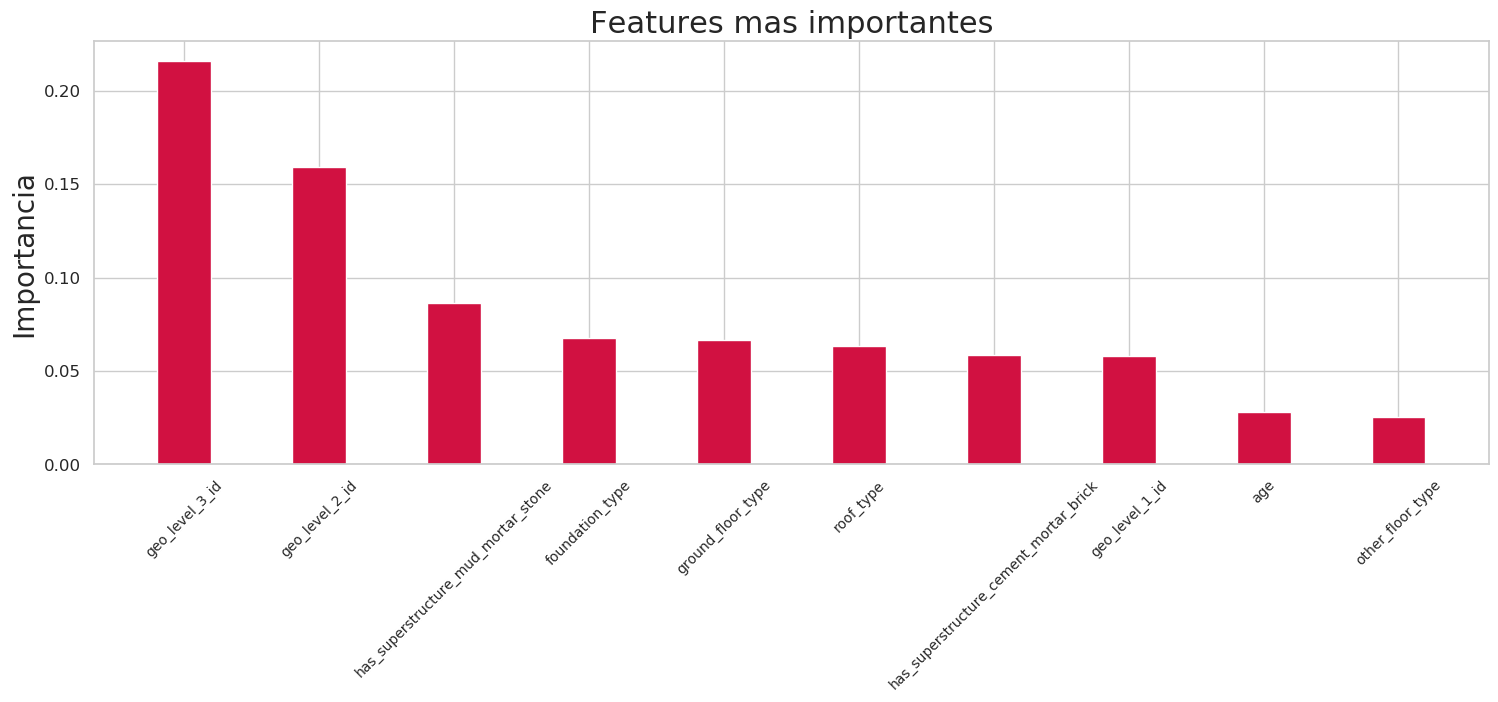

In [9]:
###grafico de features mas importantes para el modelo
###a zip pasarle array las columnas del set de train
###y array de feature importances
top_10=sorted(zip(X.columns,xg_cls.feature_importances_),key=lambda x:x[1],reverse=True)[:10]
#paso a lista para graficar
features_names = [x[0] for x in top_10]
feature_importances = [x[1] for x in top_10]

#estilizo el bar plot
plt.figure(figsize = (18, 5.5)) 
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)
plt.bar(features_names, feature_importances, color ='#d11141', width = 0.4)
plt.title("Features mas importantes", fontsize=22)
plt.ylabel("Importancia", fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [10]:
submission_format=pd.read_csv('submission_format.csv',index_col='building_id')
submission = pd.DataFrame(data=xg_cls.predict(get_features(test_values).set_index('building_id')),
                          columns=submission_format.columns,
                          index=submission_format.index)
submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [10]:
submission.to_csv('submissions/submission10.csv')
!head submissions/submission10.csv

building_id,damage_grade
300051,3
99355,2
890251,3
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2
